1. Import necessary libraries and PORT-EK source code:

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import pathlib
import pickle
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Bio import SeqIO, Align
from matplotlib import colormaps
from scipy.stats import pearsonr
from datetime import datetime
from sklearn.decomposition import PCA
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())


3030109


2. Declare data set specific definitions and functions:

In [2]:
# PORT-EK parameters
k_list = [5,7,9,11,13,15,17,19,25]  # This is the length of k-mers

# Relative path to k-mer indices
INPUT_PATH = "../output/deer/"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["deer", "humearly", "humlate"]
GROUP_OF_INTEREST = "deer"
CONTROL_GROUPS = SAMPLE_GROUPS.copy()
CONTROL_GROUPS.remove(GROUP_OF_INTEREST)

FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]
AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]

3. Construct k-mer count matrix and apply rarity filter

In [3]:
specificities = []
kmer_numbers = []
mem_size = []

k_dict = {}
for k in k_list:
    print(f"Calculating specificity and efficiency of {k}-mers.")
    kmer_set = set()
    sample_list = []
    kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*_{k}mer_set.pkl")
    sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

    for filename in kmer_set_in_path:
        with open(filename, mode="rb") as in_file:
            partial_set = pickle.load(in_file)
        kmer_set.update(partial_set)

    for filename in sample_list_in_path:
        with open(filename, mode="rb") as in_file:
            partial_list = pickle.load(in_file)
        group = filename.stem.split("_")[0]
        partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
        sample_list.extend(partial_list)
    sample_list.sort()

    all_kmer_matrix = pd.DataFrame(
        0, index=list(kmer_set), columns=sample_list, dtype="uint8"
    )

    group_sample_idx = {
        f"{group}": [
            sample for sample in sample_list if sample.split("_")[0] == f"{group}"
        ]
        for group in SAMPLE_GROUPS
    }

    in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

    for filename in in_path:
        with open(filename, mode="rb") as in_file:
            temp_dict = pickle.load(in_file)
        sample_name = "_".join(filename.stem.split("_")[:-1])
        count_dict = {f"{sample_name}": temp_dict.values()}
        temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
        all_kmer_matrix.update(temp_df)

    all_kmer_matrix.index = all_kmer_matrix.index.map(
        lambda id: portek.decode_kmer(id, k)
    )

    for group in SAMPLE_GROUPS:
        all_kmer_matrix[f"{group}_freq"] = (
            all_kmer_matrix.loc[:, group_sample_idx[group]] > 0
        ).mean(axis=1)
        all_kmer_matrix[f"{group}_avg"] = all_kmer_matrix.loc[
            :, group_sample_idx[group]
        ].mean(axis=1)

    if k * "A" in all_kmer_matrix.index:
        all_kmer_matrix = all_kmer_matrix.drop(k * "A")

    mean_count = all_kmer_matrix.loc[:, sample_list].mean(axis=None)

    ERR_COLS = []
    for j in range(len(CONTROL_GROUPS)):
        err_name = f"{GROUP_OF_INTEREST}-{CONTROL_GROUPS[j]}_err_"
        ERR_COLS.append(err_name)
        all_kmer_matrix[err_name] = (
            all_kmer_matrix[f"{GROUP_OF_INTEREST}_avg"]
            - all_kmer_matrix[f"{CONTROL_GROUPS[j]}_avg"]
        )
    all_kmer_matrix["RMSE_norm"] = (
        np.sqrt(((all_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1)) / mean_count
    )

    specificity = all_kmer_matrix["RMSE_norm"].mean()
    n_kmers = len(all_kmer_matrix)

    specificity = all_kmer_matrix["RMSE_norm"].mean()
    n_kmers = len(all_kmer_matrix)
    df_mem = all_kmer_matrix.memory_usage(index=True, deep=True).sum()
    specificities.append(specificity)
    kmer_numbers.append(n_kmers)
    mem_size.append(df_mem)
    del all_kmer_matrix
    print(
        f"Done calculating specificty ({specificity}), efficiency ({n_kmers}) of {k}-mers. The resulting data frame takes up {round(df_mem/1024/1024, 2)} MB."
    )

Calculating specificity and efficiency of 5-mers.
Done calculating specificty (0.014546890170561296), efficiency (1023) of 5-mers. The resulting data frame takes up 33.07 MB.
Calculating specificity and efficiency of 7-mers.
Done calculating specificty (0.027636162855239878), efficiency (16089) of 7-mers. The resulting data frame takes up 520.2 MB.
Calculating specificity and efficiency of 9-mers.
Done calculating specificty (0.041545730703540784), efficiency (127315) of 9-mers. The resulting data frame takes up 4116.64 MB.
Calculating specificity and efficiency of 11-mers.
Done calculating specificty (0.050519833535513405), efficiency (258242) of 11-mers. The resulting data frame takes up 8350.57 MB.
Calculating specificity and efficiency of 13-mers.
Done calculating specificty (0.05770218989479812), efficiency (322222) of 13-mers. The resulting data frame takes up 10420.06 MB.
Calculating specificity and efficiency of 15-mers.
Done calculating specificty (0.06457456234939214), effici

{5: 0.001454894094600074, 7: 0.0032927359253240064, 9: 0.004660983706549465, 11: 0.008795369901473726, 13: 0.02249186165049103, 15: 0.033574602614340754, 17: 0.03901753798301625, 19: 0.043107569357142946, 25: 0.05082539978794806}
25


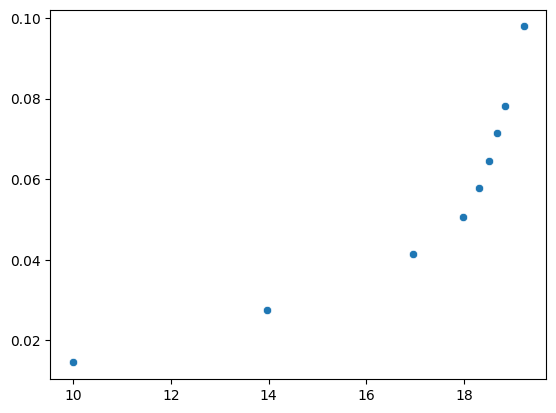

In [4]:
log_kmer_numbers = np.log2(kmer_numbers)
sns.scatterplot(x=log_kmer_numbers, y=specificities)
slope = {}
slope[k_list[0]] = specificities[0]/log_kmer_numbers[0]
for i in range(1,len(specificities)):
    slope[k_list[i]] = (specificities[i]-specificities[i-1])/(log_kmer_numbers[i]-log_kmer_numbers[i-1])

print(slope)

best = max(slope, key=slope.get)
print(best)

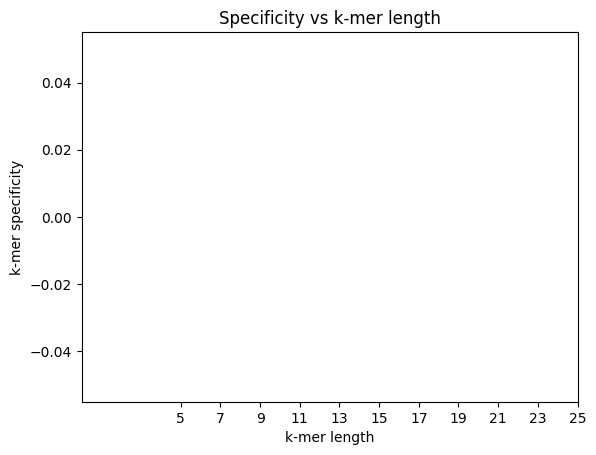

In [5]:
fig, ax = plt.subplots()
ax.set_title("Specificity vs k-mer length")
ax.set_xlabel("k-mer length")
ax.set_xticks(range(5,27,2))
ax.set_ylabel("k-mer specificity")
sns.scatterplot(x=k_list, y=[val[0] for val in k_dict.values()])
plt.show()

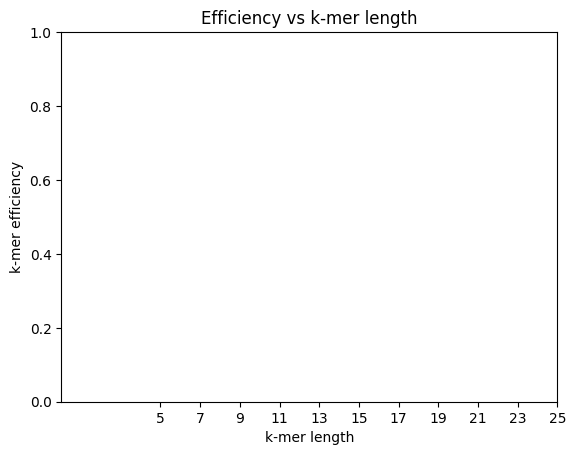

In [6]:
fig, ax = plt.subplots()
ax.set_title("Efficiency vs k-mer length")
ax.set_xlabel("k-mer length")
ax.set_xticks(range(5,27,2))
ax.set_ylabel("k-mer efficiency")
ax.set_ylim(0,1)
sns.scatterplot(x=k_list, y=[val[1] for val in k_dict.values()])
plt.show()

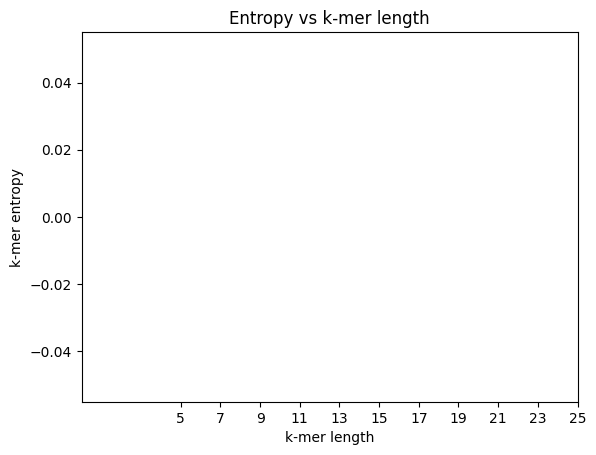

In [7]:
fig, ax = plt.subplots()
ax.set_title("Entropy vs k-mer length")
ax.set_xlabel("k-mer length")
ax.set_xticks(range(5,27,2))
ax.set_ylabel("k-mer entropy")
sns.scatterplot(x=k_list, y=[val[2] for val in k_dict.values()])
plt.show()